In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
from keras.callbacks import EarlyStopping

# Loading the data

In [6]:
labels = ['flip', 'notflip']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data('./images/training')
val = get_data('./images/validation')

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_14916/4225688101.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Visualizing data

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

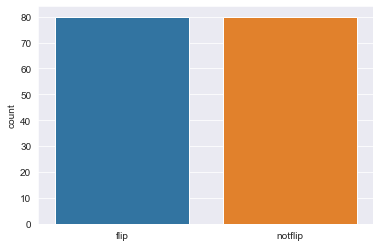

In [9]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("flip")
    else:
        l.append("notflip")
        sns.set_style('darkgrid')
        sns.countplot(l)

Reading random records from both the classes

Text(0.5, 1.0, 'flip')

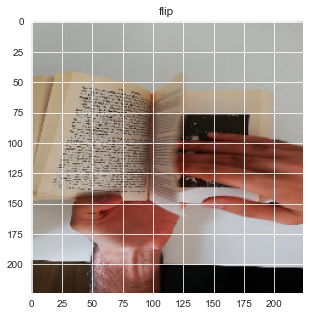

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'notflip')

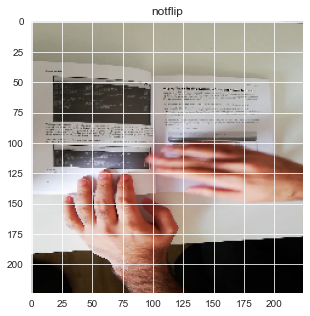

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Preprocessing data

In [106]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [114]:
print(x_train.shape)

(2232, 224, 224, 3)


Applying data augmentation for adding random transformation to images for adding diversity

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Creating CNN for training.

In [13]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [15]:
# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
history = model.fit(x_train,y_train,epochs = 150 , validation_data = (x_val, y_val),callbacks=[early_stopping])

Epoch 1/150
70/70 [==============================] - 31s 435ms/step - loss: 0.4134 - accuracy: 0.8683 - val_loss: 0.4000 - val_accuracy: 0.9000
Epoch 2/150
38/70 [===============>..............] - ETA: 12s - loss: 0.4078 - accuracy: 0.8865

KeyboardInterrupt: 

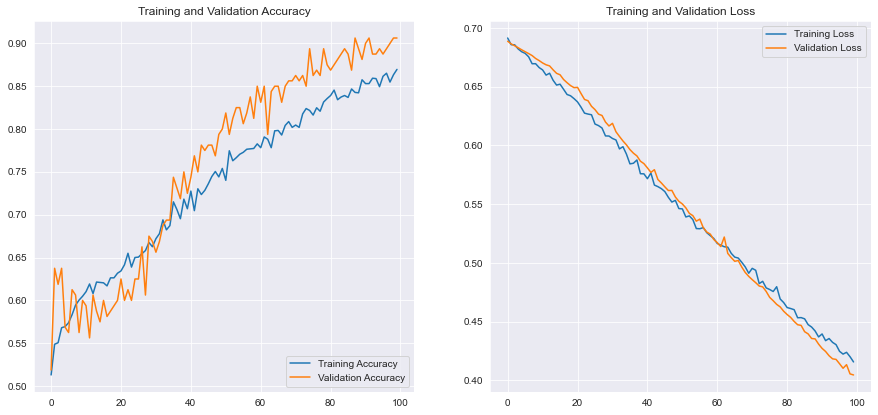

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('model-01.h5')

In [29]:
# Load the trained model
model = load_model('model-01.h5')

In [46]:
test = get_data('./images/new_testing')

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_14916/4225688101.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [54]:
# Prepare the test data
x_test = []
y_test = []


for feature, label in test:
    x_test.append(feature)
    y_test.append(label)


# Normalize the data
x_test = np.array(x_test) / 255


x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

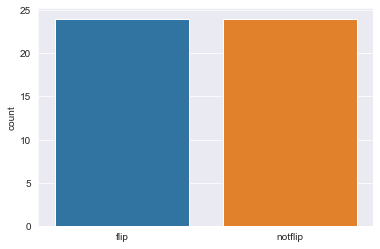

In [49]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("flip")
    else:
        l.append("notflip")
        sns.set_style('darkgrid')
        sns.countplot(l)

In [55]:
print(y_test.shape)

(48,)


In [97]:
predictions = model.predict(x_test)

In [98]:
scores = []
for i in predictions:
    scores.append(np.argmax(i))
res = np.array(scores)

In [99]:
accuracy = accuracy_score(y_test, res)
print('Accuracy:', accuracy)
print(classification_report(y_test, res, target_names = ['flip (Class 0)','notflip (Class 1)']))

Accuracy: 0.8125
                   precision    recall  f1-score   support

   flip (Class 0)       1.00      0.62      0.77        24
notflip (Class 1)       0.73      1.00      0.84        24

         accuracy                           0.81        48
        macro avg       0.86      0.81      0.81        48
     weighted avg       0.86      0.81      0.81        48

